In [4]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

In [5]:
sp500_companies = pd.read_csv('sp500_companies.csv')
sp500_index = pd.read_csv('sp500_index.csv')
sp500_stocks = pd.read_csv('sp500_stocks.csv')

print(sp500_companies.info())
print(sp500_index.info())
print(sp500_stocks.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Exchange             503 non-null    object 
 1   Symbol               503 non-null    object 
 2   Shortname            503 non-null    object 
 3   Longname             503 non-null    object 
 4   Sector               503 non-null    object 
 5   Industry             503 non-null    object 
 6   Currentprice         503 non-null    float64
 7   Marketcap            503 non-null    int64  
 8   Ebitda               474 non-null    float64
 9   Revenuegrowth        502 non-null    float64
 10  City                 503 non-null    object 
 11  State                483 non-null    object 
 12  Country              503 non-null    object 
 13  Fulltimeemployees    497 non-null    float64
 14  Longbusinesssummary  503 non-null    object 
 15  Weight               503 non-null    flo

In [6]:
# Convert date columns to datetime format for accurate merging
sp500_stocks['Date'] = pd.to_datetime(sp500_stocks['Date'])
sp500_index['Date'] = pd.to_datetime(sp500_index['Date'])

In [7]:
# Clean data

# Drop NA values from each dataframe
sp500_companies.dropna(inplace=True)
sp500_index.dropna(inplace=True)
sp500_stocks.dropna(inplace=True)

# Confirm the data is cleaned
print(sp500_companies.isna().sum())
print(sp500_index.isna().sum())
print(sp500_stocks.isna().sum())

Exchange               0
Symbol                 0
Shortname              0
Longname               0
Sector                 0
Industry               0
Currentprice           0
Marketcap              0
Ebitda                 0
Revenuegrowth          0
City                   0
State                  0
Country                0
Fulltimeemployees      0
Longbusinesssummary    0
Weight                 0
dtype: int64
Date      0
S&P500    0
dtype: int64
Date         0
Symbol       0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


In [34]:
# Ask user for inputs
risk_tolerance = float(input("Enter your risk tolerance (1 = Low, 10 = High): "))
investment_horizon = input("Enter your investment horizon (Short-term, Medium-term, Long-term): ")
sectors = input("Enter preferred sectors (comma-separated, e.g., Technology, Healthcare): ").split(',')
initial_investment = float(input("Enter your initial investment amount ($): "))



Enter your risk tolerance (1 = Low, 10 = High):  10
Enter your investment horizon (Short-term, Medium-term, Long-term):  Short-term
Enter preferred sectors (comma-separated, e.g., Technology, Healthcare):  Technology
Enter your initial investment amount ($):  1000


In [119]:
# Filter stocks based on selected sectors
filtered_stocks = sp500_companies[sp500_companies['Sector'].isin(sectors)]
filtered_symbols = filtered_stocks['Symbol'].unique()

# Calculate daily returns using .loc
filtered_returns.loc[:, 'Daily_Return'] = filtered_returns.groupby('Symbol')['Close'].pct_change()

In [120]:
# Calculate mean returns
mean_returns = filtered_returns.groupby('Symbol')['Daily_Return'].mean()
print("Mean Returns:")
print(mean_returns)

# Annualize mean returns
mean_returns *= 252
print("Annualized Mean Returns:")
print(mean_returns)

# Calculate covariance matrix
cov_matrix = filtered_returns.pivot(index='Date', columns='Symbol', values='Daily_Return').cov()
cov_matrix *= 252  # Annualize the covariance matrix
print("Covariance Matrix:")
print(cov_matrix)

Mean Returns:
Symbol
AAPL    0.001076
ADBE    0.000899
ADI     0.000700
ADP     0.000646
ADSK    0.000912
          ...   
TXN     0.000691
TYL     0.001067
UBER    0.001037
VRSN    0.000679
ZBRA    0.000948
Name: Daily_Return, Length: 74, dtype: float64
Annualized Mean Returns:
Symbol
AAPL    0.271203
ADBE    0.226671
ADI     0.176517
ADP     0.162807
ADSK    0.229923
          ...   
TXN     0.174006
TYL     0.268968
UBER    0.261230
VRSN    0.171226
ZBRA    0.239017
Name: Daily_Return, Length: 74, dtype: float64
Covariance Matrix:
Symbol      AAPL      ADBE       ADI       ADP      ADSK      AKAM      AMAT  \
Symbol                                                                         
AAPL    0.078407  0.044830  0.042594  0.028837  0.048766  0.032717  0.053011   
ADBE    0.044830  0.102018  0.050089  0.035511  0.071766  0.043433  0.061585   
ADI     0.042594  0.050089  0.085533  0.034277  0.059060  0.036562  0.077819   
ADP     0.028837  0.035511  0.034277  0.047716  0.040283  0.

In [133]:
# Adjust risk tolerance for optimization
adjusted_risk_tolerance = risk_tolerance * 5.0

# Define the Sharpe ratio objective function with adjusted risk tolerance
def sharpe_ratio(weights):
    port_return = np.dot(mean_returns.values, weights)
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix.values, weights)))
    
    # Return the negative Sharpe ratio (maximize Sharpe ratio)
    return -1 * (port_return / (port_risk + adjusted_risk_tolerance))  # Incorporate adjusted risk tolerance

In [135]:
# Get top 10 stocks
top_10_stocks = mean_returns.nlargest(10).index
print("Top 10 Stocks:")
print(top_10_stocks)

# Filter covariance matrix for top 10 stocks
top_10_cov_matrix = cov_matrix.loc[top_10_stocks, top_10_stocks]
print("Top 10 Covariance Matrix:")
print(top_10_cov_matrix.shape)

# Initialize weights for optimization
top_10_weights = np.ones(len(top_10_stocks)) / len(top_10_stocks)
print("Initial Weights for Top 10 Stocks:")
print(top_10_weights.shape)

Top 10 Stocks:
Index(['PLTR', 'ENPH', 'NVDA', 'CRWD', 'ANET', 'NOW', 'AVGO', 'DELL', 'FICO',
       'FTNT'],
      dtype='object', name='Symbol')
Top 10 Covariance Matrix:
(10, 10)
Initial Weights for Top 10 Stocks:
(10,)


In [137]:
# Set bounds for optimization for top 10 stocks
bounds = [(0.05, 0.3) for _ in range(len(top_10_stocks))]  # Minimum 5% allocation

In [138]:
# Define the Sharpe ratio objective function with adjusted risk tolerance
def sharpe_ratio(weights):
    port_return = np.dot(mean_returns[top_10_stocks].values, weights)
    port_risk = np.sqrt(np.dot(weights.T, np.dot(top_10_cov_matrix.values, weights)))
    
    # Return the negative Sharpe ratio (maximize Sharpe ratio)
    return -1 * (port_return / (port_risk + 1e-6))  # Adding a small value to avoid division by zero

In [140]:
# Optimize the portfolio using the Sharpe ratio objective function
result = minimize(sharpe_ratio, top_10_weights, bounds=bounds, constraints=[{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}])
print("Optimization Result:")
print(result)

Optimization Result:
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.4007252852823642
       x: [ 7.621e-02  5.000e-02  7.354e-02  5.000e-02  1.378e-01
            5.000e-02  1.165e-01  1.544e-01  2.416e-01  5.000e-02]
     nit: 6
     jac: [-2.158e-02  7.204e-02 -2.247e-02  2.559e-01 -2.144e-02
            9.003e-03 -2.167e-02 -2.132e-02 -2.152e-02  8.245e-03]
    nfev: 66
    njev: 6


In [141]:
# Get optimal weights for the top 10 stocks
optimal_weights = pd.Series(result.x, index=top_10_stocks)
print("Optimal Weights:", optimal_weights)

Optimal Weights: Symbol
PLTR    0.076213
ENPH    0.050000
NVDA    0.073544
CRWD    0.050000
ANET    0.137777
NOW     0.050000
AVGO    0.116469
DELL    0.154352
FICO    0.241644
FTNT    0.050000
dtype: float64


In [143]:
# Calculate annualized return and risk for the top 10 stocks
annualized_return = np.dot(mean_returns[top_10_stocks].values, optimal_weights.values)
portfolio_variance = np.dot(optimal_weights.T, np.dot(top_10_cov_matrix.values, optimal_weights))
annualized_risk = np.sqrt(portfolio_variance)

print("Annualized Return:", annualized_return)
print("Portfolio Variance:", portfolio_variance)
print("Annualized Risk:", annualized_risk)

Annualized Return: 0.41504847922242155
Portfolio Variance: 0.0877988415317426
Annualized Risk: 0.2963086929736328


In [144]:
annualized_return_percentage = annualized_return * 100
portfolio_variance_percentage = portfolio_variance * 100
annualized_risk_percentage = annualized_risk * 100

print(f"\nAnnualized Portfolio Return: {annualized_return_percentage:.2f}%")
print(f"Annualized Portfolio Variance: {portfolio_variance_percentage:.2f}")
print(f"Annualized Portfolio Risk: {annualized_risk_percentage:.2f}%")


Annualized Portfolio Return: 41.50%
Annualized Portfolio Variance: 8.78
Annualized Portfolio Risk: 29.63%


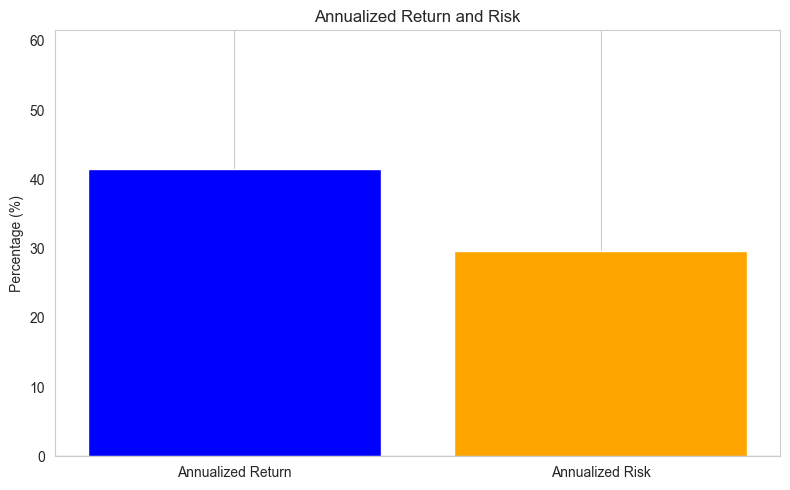

In [146]:
import matplotlib.pyplot as plt

# Data for visualization
labels = ['Annualized Return', 'Annualized Risk']
values = [annualized_return_percentage, annualized_risk_percentage]

# Create bar chart
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'orange'])
plt.ylabel('Percentage (%)')
plt.title('Annualized Return and Risk')
plt.ylim(0, max(values) + 20)  # Adding some padding
plt.axhline(y=0, color='k', linewidth=0.8)  # Line at y=0
plt.grid(axis='y')

# Show plot
plt.tight_layout()
plt.show()

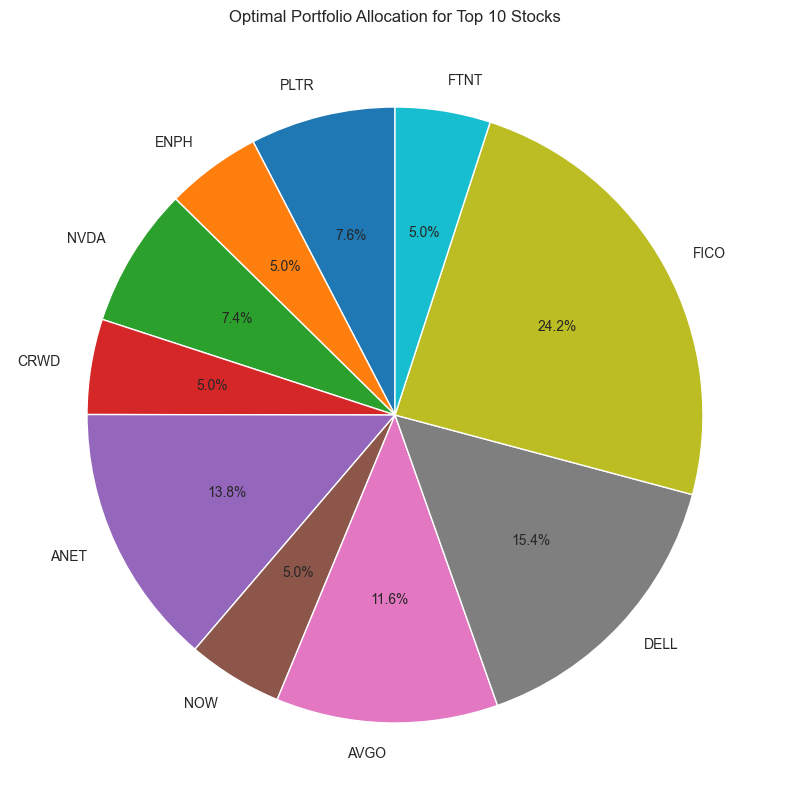

In [149]:
# Plot pie chart for optimal weights
plt.figure(figsize=(10, 10))
optimal_weights.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Optimal Portfolio Allocation for Top 10 Stocks')
plt.ylabel('')  # Hide the y-label
plt.grid(False)  # Remove grid
plt.show()

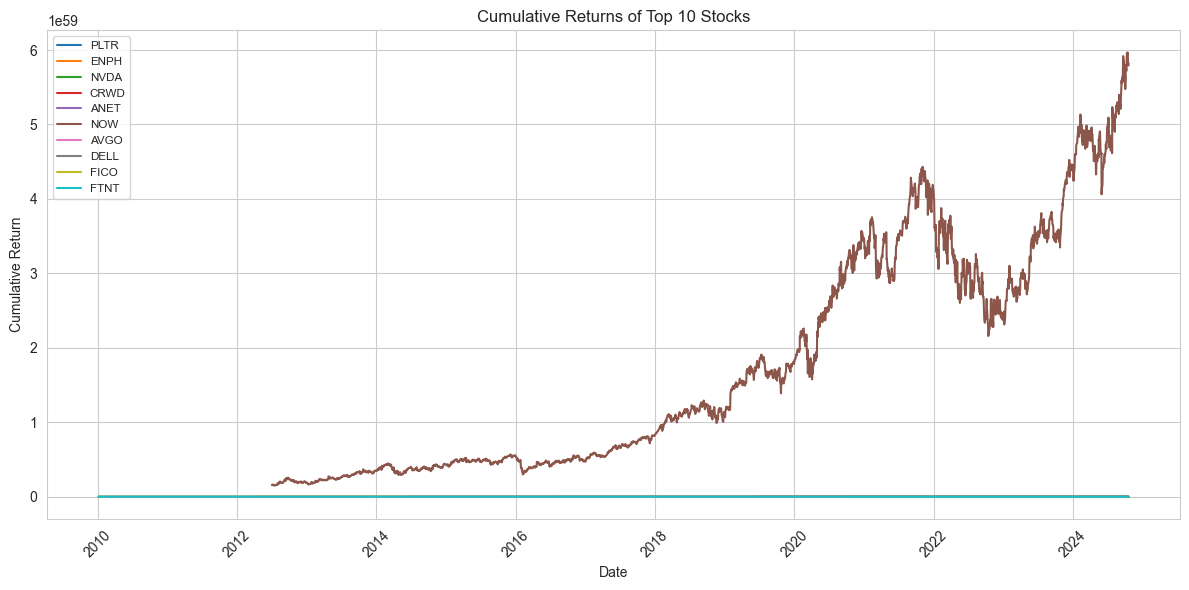

In [150]:
# Calculate cumulative returns for the top 10 stocks
filtered_returns['Cumulative_Return'] = (1 + filtered_returns['Daily_Return']).cumprod()

plt.figure(figsize=(12, 6))
for symbol in top_10_stocks:
    symbol_data = filtered_returns[filtered_returns['Symbol'] == symbol]
    plt.plot(symbol_data['Date'], symbol_data['Cumulative_Return'], label=symbol)

plt.title("Cumulative Returns of Top 10 Stocks")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(loc='upper left', fontsize='small')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

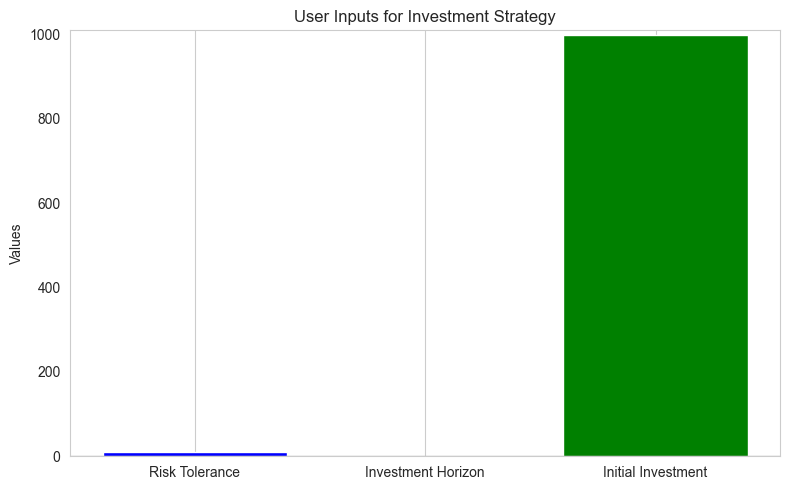

In [151]:
import matplotlib.pyplot as plt

# User inputs for visualization
user_inputs = {
    'Risk Tolerance': risk_tolerance,
    'Investment Horizon': investment_horizon,
    'Initial Investment': initial_investment
}

# Convert investment horizon to numeric for visualization
horizon_mapping = {'Short-term': 1, 'Medium-term': 2, 'Long-term': 3}
user_inputs['Investment Horizon'] = horizon_mapping.get(investment_horizon, 0)

# Create bar chart
plt.figure(figsize=(8, 5))
plt.bar(user_inputs.keys(), user_inputs.values(), color=['blue', 'orange', 'green'])
plt.title('User Inputs for Investment Strategy')
plt.ylabel('Values')
plt.ylim(0, max(user_inputs.values()) + 10)  # Add some padding
plt.axhline(y=0, color='k', linewidth=0.8)  # Line at y=0
plt.grid(axis='y')

# Show plot
plt.tight_layout()
plt.show()

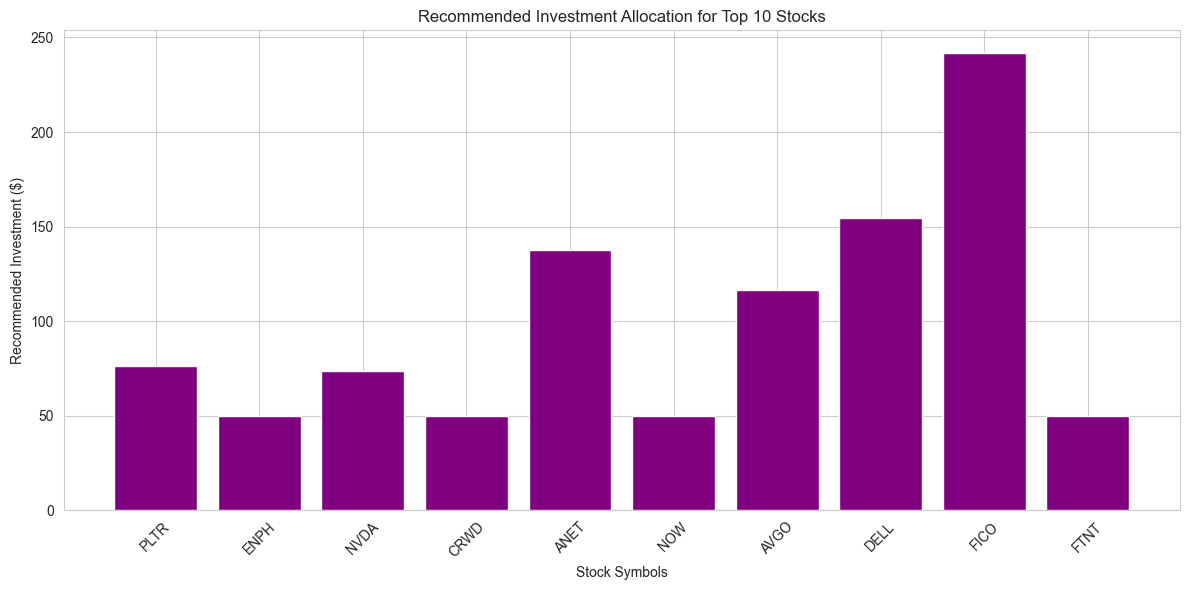

In [153]:
# Compare user inputs with recommended investments
recommended_investment = optimal_weights * initial_investment  # Assuming top_10_optimal_weights is defined

# Create DataFrame for easy plotting
allocation_data = pd.DataFrame({
    'Stocks': recommended_investment.index,
    'Recommended Investment': recommended_investment.values
})

# Create bar chart for recommended investment allocation
plt.figure(figsize=(12, 6))
plt.bar(allocation_data['Stocks'], allocation_data['Recommended Investment'], color='purple')
plt.title('Recommended Investment Allocation for Top 10 Stocks')
plt.xlabel('Stock Symbols')
plt.ylabel('Recommended Investment ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Merge sp500_stocks with sp500_companies on 'Symbol'
merged_stocks_companies = pd.merge(sp500_stocks, sp500_companies, on='Symbol', how='inner')

# Now merge the result with sp500_index on 'Date'
# If you want to keep all stock data, you can use 'outer' or 'left' merge
final_merged_df = pd.merge(merged_stocks_companies, sp500_index, on='Date', how='outer')

# Display the result
print(final_merged_df.head())
print(final_merged_df.shape)

        Date Symbol  Adj Close      Close       High        Low       Open  \
0 2010-01-04    MMM  44.016735  69.414719  69.774246  69.122070  69.473244   
1 2010-01-04    AOS   5.963981   7.435000   7.480000   7.261667   7.295000   
2 2010-01-04    ABT  19.778837  26.129908  26.177889  25.870815  26.000362   
3 2010-01-04   ADBE  37.090000  37.090000  37.299999  36.650002  36.650002   
4 2010-01-04    AMD   9.700000   9.700000   9.900000   9.680000   9.790000   

       Volume Exchange                     Shortname  ...     Marketcap  \
0   3640265.0      NYQ                    3M Company  ...   74239696896   
1   1104600.0      NYQ        A.O. Smith Corporation  ...   11485293568   
2  10829095.0      NYQ           Abbott Laboratories  ...  207726657536   
3   4710200.0      NMS                    Adobe Inc.  ...  217854984192   
4  18748700.0      NMS  Advanced Micro Devices, Inc.  ...  252434333696   

         Ebitda Revenuegrowth           City  State        Country  \
0  7.35000

In [10]:
import pandas as pd

# Load the Stock Portfolio Performance dataset
portfolio_data = pd.read_csv('https://archive.ics.uci.edu/static/public/390/data.csv')

In [11]:
print(portfolio_data.head())
print(portfolio_data.info())

  period  ID  Large B/P  Large ROE  Large S/P  \
0    all   1        1.0        0.0        0.0   
1    all   2        0.0        1.0        0.0   
2    all   3        0.0        0.0        1.0   
3    all   4        0.0        0.0        0.0   
4    all   5        0.0        0.0        0.0   

   Large Return Rate in the last quarter  Large Market Value  \
0                                    0.0                 0.0   
1                                    0.0                 0.0   
2                                    0.0                 0.0   
3                                    1.0                 0.0   
4                                    0.0                 1.0   

   Small systematic Risk Annual Return Excess Return  Systematic Risk  \
0                    0.0        13.90%         1.00%             1.33   
1                    0.0        14.30%         1.00%             1.17   
2                    0.0        17.30%         1.80%             1.30   
3                    0.0    

In [12]:
# Assuming your existing data is in a DataFrame called `sp500_data`
combined_data = pd.merge(final_merged_df, portfolio_data, on='Symbol', how='outer')

print(combined_data.head())
print(combined_data.info())

KeyError: 'Symbol'